# Assumption Stress Testing: Deliberately Breaking Assumptions

This notebook demonstrates **assumption stress testing** - a validation technique that systematically breaks key assumptions to see how recommendations depend on them.

Understanding assumption stress testing is essential because:
- **Assumptions are often wrong** - you need to know what happens when they are
- **Stress testing reveals critical assumptions** - shows which assumptions matter most
- **It helps you prioritize** - invest effort in getting accurate estimates for critical assumptions
- **It prepares you for surprises** - you know what to do when assumptions are wrong


## Key Concepts

**Assumption Stress Testing** systematically breaks assumptions:
- You take each key assumption and make it wrong
- You observe how the recommendation changes
- You identify which assumptions are critical (cause big changes)
- You identify which assumptions are less critical (cause small changes)

**Why It Matters**:
- **Assumptions are often wrong** - stress testing prepares you for when they are
- **Critical assumptions need accurate estimates** - invest effort where it matters
- **Less critical assumptions can use rough estimates** - don't waste effort
- **Stress testing reveals dependencies** - shows how recommendations depend on assumptions

**Critical insight**: Assumption stress testing is like stress-testing a bridge - you push it to find breaking points so you know when it's safe to use.


## Scenario: Staffing Model with Multiple Assumptions

You manage a call center and use a model to recommend staffing levels. The model makes several key assumptions:
- **Patient arrival rate**: 40 patients per hour (but could be 30-50)
- **Average service time**: 15 minutes per patient (but could be 10-20)
- **Staff cost**: $25 per hour (but could be $20-30)
- **Minimum staffing requirement**: 5 staff (regulatory requirement)

**The Challenge**: Which assumptions matter most? What happens if each assumption is wrong?

**The Question**: How does the recommendation change when you break each assumption? Which assumptions are critical?

**Decision variables**: Staff to schedule

**Assumptions to stress-test**: Arrival rate, service time, staff cost, minimum requirement


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you need to install the `pulp` package first. This cell can be skipped if running locally and the package is already installed.


In [1]:
# Install pulp package (required for optimization)
# This is needed in Google Colab; can be skipped if already installed locally
%pip install pulp -q



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries

We'll use pandas for data manipulation and analysis, numpy for numerical calculations, matplotlib for visualizations, and pulp for solving the optimization model that determines optimal staffing levels.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, value, PULP_CBC_CMD


## Step 3: Set Up Base Model

In this step, we create the base staffing optimization model with our initial assumptions. This model will serve as our baseline for comparison when we stress-test assumptions.

**What the model does**:
- **Objective**: Minimize total staff cost for an 8-hour shift
- **Constraint**: Staff capacity must be sufficient to handle all patient arrivals
- **Decision variable**: Number of staff to schedule (must be at least the minimum required)

**Key assumptions we're making**:
- Arrival rate: 40 patients per hour (this is what we forecast, but it might be wrong)
- Service time: 15 minutes per patient (average time to serve each patient)
- Staff cost: $25 per hour (wage rate)
- Minimum staffing: 5 staff (regulatory requirement)

**Why this matters**: These assumptions form the foundation of our recommendation. If any of them are wrong, our recommendation will be wrong too. That's why we need to stress-test them.


In [3]:
def solve_staffing_model(arrival_rate, service_time_minutes, staff_cost_per_hour, min_staffing=5):
    """
    Solve staffing optimization model.
    Objective: Minimize total staff cost
    Constraint: Must handle all arrivals (staff capacity >= arrival load)
    Returns: (staff_recommended, total_cost)
    """
    # Create model
    model = LpProblem("Staffing_Optimization", LpMinimize)
    
    # Decision variable: Number of staff to schedule
    staff = LpVariable("staff", lowBound=min_staffing, cat='Integer')
    
    # Objective: Minimize total cost
    # Assume 8-hour shift
    hours_per_shift = 8
    total_cost = staff * staff_cost_per_hour * hours_per_shift
    model += total_cost, "Total_Cost"
    
    # Constraint: Staff capacity must handle arrivals
    # Each staff can handle: 60 minutes / service_time_minutes patients per hour
    patients_per_staff_per_hour = 60 / service_time_minutes
    total_capacity = staff * patients_per_staff_per_hour * hours_per_shift
    model += total_capacity >= arrival_rate * hours_per_shift, "Meet_Demand"
    
    # Solve
    model.solve(PULP_CBC_CMD(msg=0))
    
    # Get results
    staff_recommended = value(staff)
    total_cost_val = value(model.objective)
    
    return (staff_recommended, total_cost_val)

# Base assumptions
base_arrival_rate = 40  # patients per hour
base_service_time = 15  # minutes per patient
base_staff_cost = 25    # dollars per hour
base_min_staffing = 5   # minimum required

# Solve base model
base_staff, base_cost = solve_staffing_model(
    base_arrival_rate, base_service_time, base_staff_cost, base_min_staffing
)

print("BASE MODEL (Normal Assumptions):")
print("=" * 80)
print(f"  Arrival Rate: {base_arrival_rate} patients/hour")
print(f"  Service Time: {base_service_time} minutes/patient")
print(f"  Staff Cost: ${base_staff_cost}/hour")
print(f"  Minimum Staffing: {base_min_staffing}")
print(f"\n  Recommendation: Schedule {base_staff:.0f} staff")
print(f"  Total Cost: ${base_cost:,.0f}")


BASE MODEL (Normal Assumptions):
  Arrival Rate: 40 patients/hour
  Service Time: 15 minutes/patient
  Staff Cost: $25/hour
  Minimum Staffing: 5

  Recommendation: Schedule 10 staff
  Total Cost: $2,000


## Step 4: Stress Test Each Assumption

This is the core of assumption stress testing. We systematically break each assumption one at a time to see how sensitive our recommendations are to each assumption.

**What we're doing**:
- For each key assumption (arrival rate, service time, staff cost), we test a range of values
- We keep all other assumptions at their base values
- We observe how the staff recommendation and total cost change
- We calculate the magnitude of changes (both absolute and percentage)

**Why this approach**:
- By changing one assumption at a time, we can isolate the impact of each assumption
- This helps us identify which assumptions are critical (cause big changes) vs less critical (cause small changes)
- Understanding sensitivity helps us prioritize where to invest effort in getting accurate estimates

**What to look for**:
- **Large changes** in staff recommendation = critical assumption (needs accurate estimate)
- **Small changes** in staff recommendation = less critical assumption (rough estimate may be sufficient)
- **Non-linear responses** = assumption has threshold effects (small errors can cause big problems)
- **Linear responses** = assumption has predictable effects (errors scale proportionally)


In [4]:
# Stress test results
stress_tests = []

# Test 1: Break Arrival Rate Assumption
print("STRESS TEST 1: Break Arrival Rate Assumption")
print("=" * 80)
arrival_rates = [30, 35, 40, 45, 50]  # Test range around base
for arr_rate in arrival_rates:
    staff, cost = solve_staffing_model(
        arr_rate, base_service_time, base_staff_cost, base_min_staffing
    )
    stress_tests.append({
        'Assumption': 'Arrival Rate',
        'Base Value': base_arrival_rate,
        'Test Value': arr_rate,
        'Change %': ((arr_rate - base_arrival_rate) / base_arrival_rate * 100),
        'Staff Recommended': staff,
        'Change in Staff': staff - base_staff,
        'Total Cost': cost,
        'Change in Cost': cost - base_cost
    })
    print(f"  Arrival Rate: {arr_rate} ({((arr_rate - base_arrival_rate) / base_arrival_rate * 100):+.1f}%)")
    print(f"    → Staff: {staff:.0f} (change: {staff - base_staff:+.0f})")
    print(f"    → Cost: ${cost:,.0f} (change: ${cost - base_cost:+,.0f})")

print("\n" + "=" * 80)


STRESS TEST 1: Break Arrival Rate Assumption
  Arrival Rate: 30 (-25.0%)
    → Staff: 8 (change: -2)
    → Cost: $1,600 (change: $-400)
  Arrival Rate: 35 (-12.5%)
    → Staff: 9 (change: -1)
    → Cost: $1,800 (change: $-200)
  Arrival Rate: 40 (+0.0%)
    → Staff: 10 (change: +0)
    → Cost: $2,000 (change: $+0)
  Arrival Rate: 45 (+12.5%)
    → Staff: 12 (change: +2)
    → Cost: $2,400 (change: $+400)
  Arrival Rate: 50 (+25.0%)
    → Staff: 13 (change: +3)
    → Cost: $2,600 (change: $+600)



In [5]:
# Test 2: Break Service Time Assumption
print("STRESS TEST 2: Break Service Time Assumption")
print("=" * 80)
service_times = [10, 12.5, 15, 17.5, 20]  # Test range around base
for svc_time in service_times:
    staff, cost = solve_staffing_model(
        base_arrival_rate, svc_time, base_staff_cost, base_min_staffing
    )
    stress_tests.append({
        'Assumption': 'Service Time',
        'Base Value': base_service_time,
        'Test Value': svc_time,
        'Change %': ((svc_time - base_service_time) / base_service_time * 100),
        'Staff Recommended': staff,
        'Change in Staff': staff - base_staff,
        'Total Cost': cost,
        'Change in Cost': cost - base_cost
    })
    print(f"  Service Time: {svc_time} min ({((svc_time - base_service_time) / base_service_time * 100):+.1f}%)")
    print(f"    → Staff: {staff:.0f} (change: {staff - base_staff:+.0f})")
    print(f"    → Cost: ${cost:,.0f} (change: ${cost - base_cost:+,.0f})")

print("\n" + "=" * 80)


STRESS TEST 2: Break Service Time Assumption
  Service Time: 10 min (-33.3%)
    → Staff: 7 (change: -3)
    → Cost: $1,400 (change: $-600)
  Service Time: 12.5 min (-16.7%)
    → Staff: 9 (change: -1)
    → Cost: $1,800 (change: $-200)
  Service Time: 15 min (+0.0%)
    → Staff: 10 (change: +0)
    → Cost: $2,000 (change: $+0)
  Service Time: 17.5 min (+16.7%)
    → Staff: 12 (change: +2)
    → Cost: $2,400 (change: $+400)
  Service Time: 20 min (+33.3%)
    → Staff: 14 (change: +4)
    → Cost: $2,800 (change: $+800)



In [6]:
# Test 3: Break Staff Cost Assumption
print("STRESS TEST 3: Break Staff Cost Assumption")
print("=" * 80)
staff_costs = [20, 22.5, 25, 27.5, 30]  # Test range around base
for stf_cost in staff_costs:
    staff, cost = solve_staffing_model(
        base_arrival_rate, base_service_time, stf_cost, base_min_staffing
    )
    stress_tests.append({
        'Assumption': 'Staff Cost',
        'Base Value': base_staff_cost,
        'Test Value': stf_cost,
        'Change %': ((stf_cost - base_staff_cost) / base_staff_cost * 100),
        'Staff Recommended': staff,
        'Change in Staff': staff - base_staff,
        'Total Cost': cost,
        'Change in Cost': cost - base_cost
    })
    print(f"  Staff Cost: ${stf_cost} ({((stf_cost - base_staff_cost) / base_staff_cost * 100):+.1f}%)")
    print(f"    → Staff: {staff:.0f} (change: {staff - base_staff:+.0f})")
    print(f"    → Cost: ${cost:,.0f} (change: ${cost - base_cost:+,.0f})")

# Create results dataframe
stress_df = pd.DataFrame(stress_tests)
print("\n" + "=" * 80)


STRESS TEST 3: Break Staff Cost Assumption
  Staff Cost: $20 (-20.0%)
    → Staff: 10 (change: +0)
    → Cost: $1,600 (change: $-400)
  Staff Cost: $22.5 (-10.0%)
    → Staff: 10 (change: +0)
    → Cost: $1,800 (change: $-200)
  Staff Cost: $25 (+0.0%)
    → Staff: 10 (change: +0)
    → Cost: $2,000 (change: $+0)
  Staff Cost: $27.5 (+10.0%)
    → Staff: 10 (change: +0)
    → Cost: $2,200 (change: $+200)
  Staff Cost: $30 (+20.0%)
    → Staff: 10 (change: +0)
    → Cost: $2,400 (change: $+400)



## Step 5: Analyze Which Assumptions Matter Most

After stress-testing each assumption, we need to analyze the results to determine which assumptions are most critical. This analysis helps us prioritize our efforts.

**What we're analyzing**:
- **Maximum changes**: What's the worst-case impact if an assumption is wrong?
- **Average changes**: What's the typical impact across the tested range?
- **Sensitivity**: How much does the recommendation change per percentage change in the assumption?
- **Criticality**: Classification of assumptions as "Critical" (high impact) vs "Less Critical" (low impact)

**Key metrics**:
- **Sensitivity (Staff)**: Change in staff recommendation per 1% change in assumption value
  - High sensitivity (>0.1) = critical assumption
  - Low sensitivity (<0.05) = less critical assumption
- **Sensitivity (Cost)**: Change in total cost per 1% change in assumption value
  - High sensitivity (>$20 per 1%) = critical assumption
  - Low sensitivity (<$10 per 1%) = less critical assumption

**Why this matters**:
- **Critical assumptions** need accurate estimates - invest time and resources to get them right
- **Less critical assumptions** can use rough estimates - don't waste effort on precision
- This prioritization helps you allocate your data collection and analysis efforts efficiently


In [7]:
# Calculate sensitivity metrics for each assumption
assumption_analysis = []

for assumption in stress_df['Assumption'].unique():
    assumption_data = stress_df[stress_df['Assumption'] == assumption]
    
    # Calculate maximum change in staff and cost
    max_staff_change = assumption_data['Change in Staff'].abs().max()
    max_cost_change = assumption_data['Change in Cost'].abs().max()
    
    # Calculate average absolute change
    avg_staff_change = assumption_data['Change in Staff'].abs().mean()
    avg_cost_change = assumption_data['Change in Cost'].abs().mean()
    
    # Calculate sensitivity (change per % change in assumption)
    avg_change_pct = assumption_data['Change %'].abs().mean()
    sensitivity_staff = avg_staff_change / avg_change_pct if avg_change_pct > 0 else 0
    sensitivity_cost = avg_cost_change / avg_change_pct if avg_change_pct > 0 else 0
    
    assumption_analysis.append({
        'Assumption': assumption,
        'Max Staff Change': max_staff_change,
        'Max Cost Change': max_cost_change,
        'Avg Staff Change': avg_staff_change,
        'Avg Cost Change': avg_cost_change,
        'Sensitivity (Staff)': sensitivity_staff,
        'Sensitivity (Cost)': sensitivity_cost,
        'Criticality': 'Critical' if max_staff_change > 2 or max_cost_change > 500 else 'Less Critical'
    })

analysis_df = pd.DataFrame(assumption_analysis)

print("ASSUMPTION CRITICALITY ANALYSIS:")
print("=" * 80)
display(analysis_df.round(2))

# Identify most critical assumptions
most_critical_staff = analysis_df.loc[analysis_df['Max Staff Change'].idxmax(), 'Assumption']
most_critical_cost = analysis_df.loc[analysis_df['Max Cost Change'].idxmax(), 'Assumption']

print(f"\nKEY FINDINGS:")
print(f"  • Most critical for staff recommendation: {most_critical_staff}")
print(f"  • Most critical for cost: {most_critical_cost}")
print(f"  • Invest more effort in getting accurate estimates for critical assumptions")
print(f"  • Less critical assumptions can use rougher estimates")


ASSUMPTION CRITICALITY ANALYSIS:


,Assumption,Max Staff Change,Max Cost Change,Avg Staff Change,Avg Cost Change,Sensitivity (Staff),Sensitivity (Cost),Criticality
0,Arrival Rate,3.0,600.0,1.6,320.0,0.11,21.33,Critical
1,Service Time,4.0,800.0,2.0,400.0,0.10,20.00,Critical
2,Staff Cost,0.0,400.0,0.0,240.0,0.00,20.00,Less Critical



KEY FINDINGS:
  • Most critical for staff recommendation: Service Time
  • Most critical for cost: Service Time
  • Invest more effort in getting accurate estimates for critical assumptions
  • Less critical assumptions can use rougher estimates


## Step 6: Visualize Assumption Impact

Visualizations make it easier to understand how assumptions affect recommendations. We'll create four key visualizations:

**Plot 1: Staff Recommendation vs Assumption Values**
- Shows how the staff recommendation changes as each assumption varies
- Steeper slopes indicate more sensitive assumptions
- Helps identify which assumptions cause the biggest changes in staffing needs

**Plot 2: Cost vs Assumption Values**
- Shows how total cost changes as each assumption varies
- Important because cost is often the primary concern
- Helps identify which assumptions have the biggest financial impact

**Plot 3: Assumption Sensitivity (Staff)**
- Bar chart comparing sensitivity scores for staff recommendations
- Color-coded: Red = critical, Orange = moderate, Green = less critical
- Makes it easy to see which assumptions need accurate estimates

**Plot 4: Assumption Sensitivity (Cost)**
- Bar chart comparing sensitivity scores for total cost
- Shows the financial impact of assumption errors
- Helps prioritize which assumptions to verify for cost control

These visualizations help you quickly identify critical assumptions and understand the relationship between assumption errors and recommendation changes.


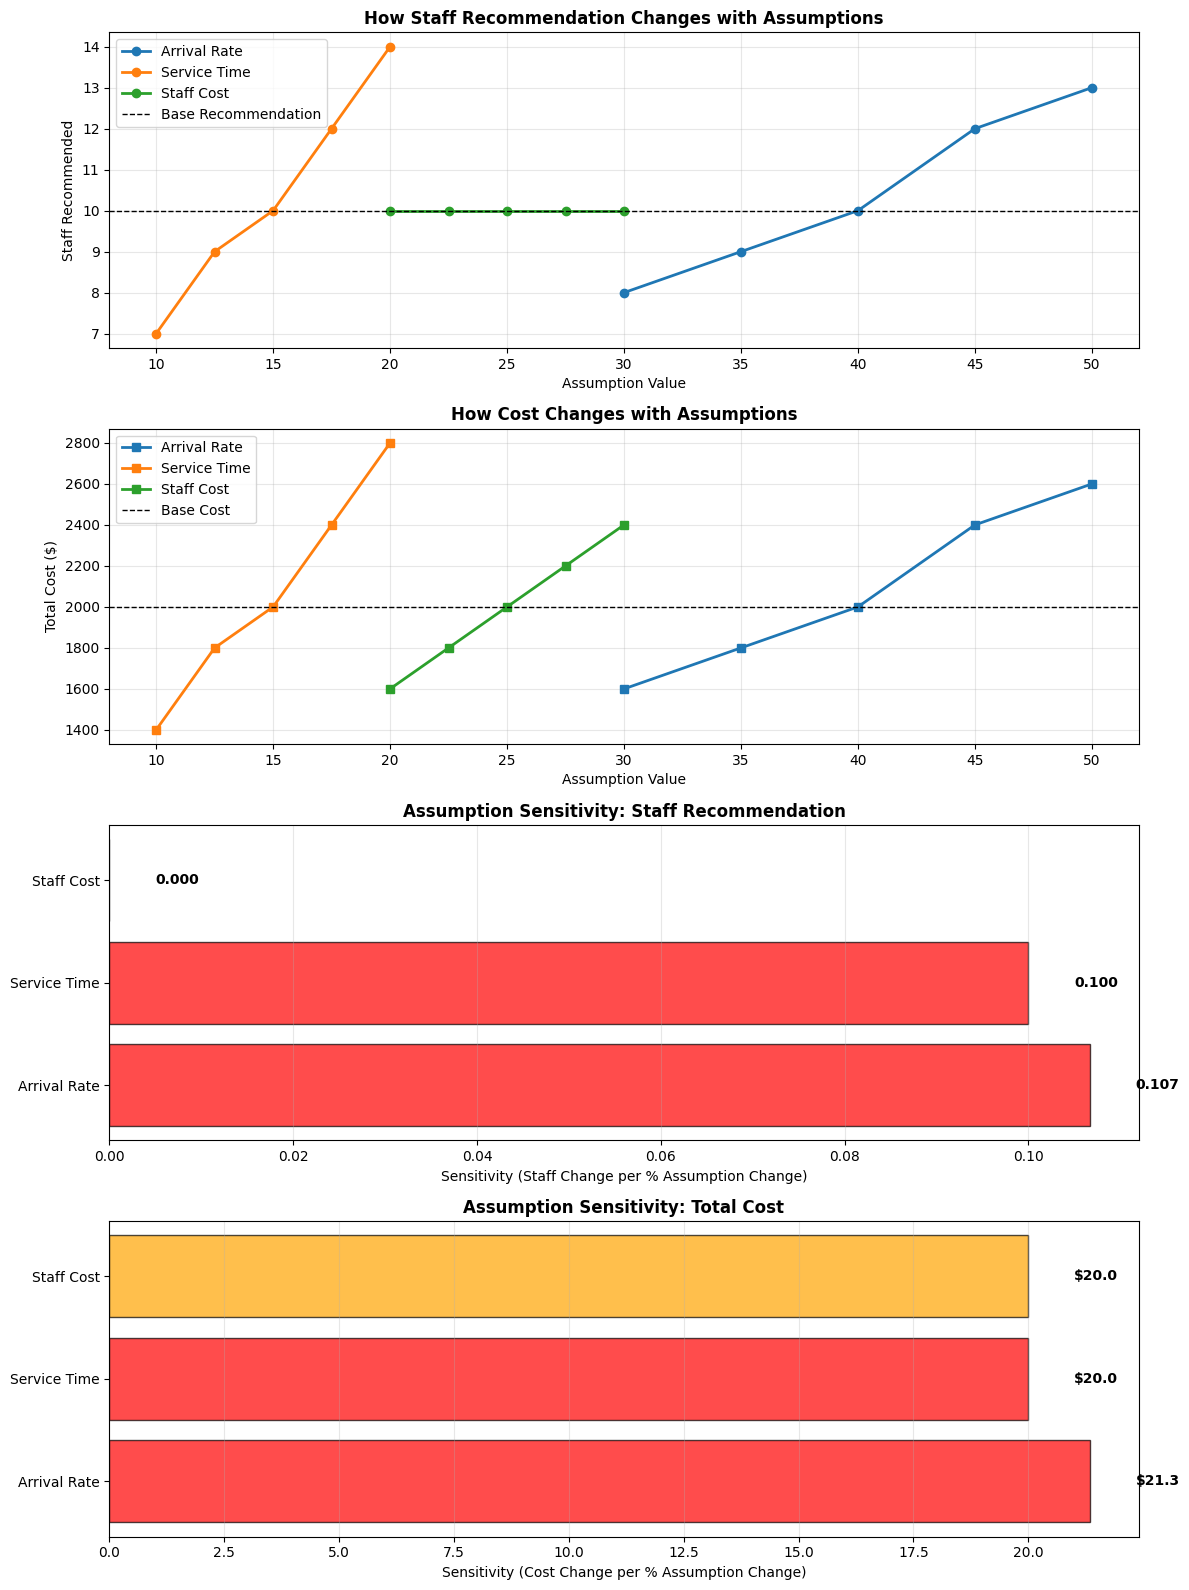

In [8]:
# Visualize - one plot per row for better readability
fig, axes = plt.subplots(4, 1, figsize=(12, 16))

# Plot 1: Staff Recommendation vs Assumption Values
ax1 = axes[0]
for assumption in stress_df['Assumption'].unique():
    data = stress_df[stress_df['Assumption'] == assumption]
    ax1.plot(data['Test Value'], data['Staff Recommended'], 
            marker='o', linewidth=2, markersize=6, label=assumption)
ax1.axhline(y=base_staff, color='black', linestyle='--', linewidth=1, label='Base Recommendation')
ax1.set_xlabel('Assumption Value')
ax1.set_ylabel('Staff Recommended')
ax1.set_title('How Staff Recommendation Changes with Assumptions', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Cost vs Assumption Values
ax2 = axes[1]
for assumption in stress_df['Assumption'].unique():
    data = stress_df[stress_df['Assumption'] == assumption]
    ax2.plot(data['Test Value'], data['Total Cost'], 
            marker='s', linewidth=2, markersize=6, label=assumption)
ax2.axhline(y=base_cost, color='black', linestyle='--', linewidth=1, label='Base Cost')
ax2.set_xlabel('Assumption Value')
ax2.set_ylabel('Total Cost ($)')
ax2.set_title('How Cost Changes with Assumptions', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Sensitivity Comparison (Staff)
ax3 = axes[2]
assumptions = analysis_df['Assumption']
sensitivities = analysis_df['Sensitivity (Staff)']
colors = ['red' if s > 0.1 else 'orange' if s > 0.05 else 'green' for s in sensitivities]
bars = ax3.barh(assumptions, sensitivities, color=colors, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Sensitivity (Staff Change per % Assumption Change)')
ax3.set_title('Assumption Sensitivity: Staff Recommendation', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
for bar, sens in zip(bars, sensitivities):
    ax3.text(sens + 0.005, bar.get_y() + bar.get_height()/2,
             f'{sens:.3f}', va='center', fontweight='bold')

# Plot 4: Sensitivity Comparison (Cost)
ax4 = axes[3]
sensitivities_cost = analysis_df['Sensitivity (Cost)']
colors_cost = ['red' if s > 20 else 'orange' if s > 10 else 'green' for s in sensitivities_cost]
bars = ax4.barh(assumptions, sensitivities_cost, color=colors_cost, alpha=0.7, edgecolor='black')
ax4.set_xlabel('Sensitivity (Cost Change per % Assumption Change)')
ax4.set_title('Assumption Sensitivity: Total Cost', fontweight='bold')
ax4.grid(axis='x', alpha=0.3)
for bar, sens in zip(bars, sensitivities_cost):
    ax4.text(sens + 1, bar.get_y() + bar.get_height()/2,
             f'${sens:.1f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [9]:
# Create priority matrix
priority_matrix = pd.DataFrame({
    'Assumption': analysis_df['Assumption'],
    'Criticality': analysis_df['Criticality'],
    'Max Impact (Staff)': analysis_df['Max Staff Change'],
    'Max Impact (Cost)': analysis_df['Max Cost Change'],
    'Priority': ['High' if c == 'Critical' else 'Medium' if m > 1 else 'Low' 
                 for c, m in zip(analysis_df['Criticality'], analysis_df['Max Staff Change'])],
    'Data Collection Effort': ['High' if c == 'Critical' else 'Medium' if m > 1 else 'Low'
                               for c, m in zip(analysis_df['Criticality'], analysis_df['Max Staff Change'])]
})

print("ASSUMPTION PRIORITY MATRIX:")
print("=" * 80)
display(priority_matrix)

print("\nRECOMMENDATIONS:")
print("  • High Priority: Invest significant effort in getting accurate estimates")
print("  • Medium Priority: Get reasonable estimates, but don't over-invest")
print("  • Low Priority: Rough estimates are sufficient")
print("\n  Focus your data collection efforts on critical assumptions!")


ASSUMPTION PRIORITY MATRIX:


,Assumption,Criticality,Max Impact (Staff),Max Impact (Cost),Priority,Data Collection Effort
0,Arrival Rate,Critical,3.0,600.0,High,High
1,Service Time,Critical,4.0,800.0,High,High
2,Staff Cost,Less Critical,0.0,400.0,Low,Low



RECOMMENDATIONS:
  • High Priority: Invest significant effort in getting accurate estimates
  • Medium Priority: Get reasonable estimates, but don't over-invest
  • Low Priority: Rough estimates are sufficient

  Focus your data collection efforts on critical assumptions!


## Summary: Assumption Stress Testing

**What We Learned**:
- **Assumption stress testing** systematically breaks each key assumption to see how recommendations depend on them
- **Critical assumptions** cause large changes in recommendations - these need accurate estimates
- **Less critical assumptions** cause small changes - rough estimates may be sufficient
- **Stress testing reveals priorities** - helps you focus data collection efforts where they matter most

**Key Insights**:
1. **Test each assumption systematically**: Break one assumption at a time and observe changes
2. **Identify critical assumptions**: Those that cause large changes are critical
3. **Prioritize data collection**: Invest effort in getting accurate estimates for critical assumptions
4. **Prepare for when assumptions are wrong**: Know what to do when critical assumptions are incorrect

**Practical Application**:
- Always perform assumption stress testing to identify critical assumptions
- Focus data collection efforts on assumptions that matter most
- Don't waste effort refining estimates for less critical assumptions
- Prepare contingency plans for when critical assumptions are wrong
- Use stress testing to understand model dependencies and risks
